In [1]:
import pandas as pd
df_balanced = pd.read_csv('lenta-ru-news_balanced.csv')  # укажи правильный путь к файлу

# Нейросетевые модели

# FastText

In [3]:
# 1️⃣ Подготовка данных
import pandas as pd
from sklearn.model_selection import train_test_split

texts = df_balanced['text']
labels = df_balanced['topic']

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# --- Подготовка данных в формате fastText ---
def prepare_fasttext_format(texts, labels, filepath):
    with open(filepath, 'w', encoding='utf-8') as f:
        for text, label in zip(texts, labels):
            clean_text = text.strip().replace('\n', ' ').replace('\r', ' ')
            line = f"__label__{label} {clean_text}\n"
            f.write(line)

# Сохраняем train и test
prepare_fasttext_format(X_train, y_train, 'fasttext_train.txt')
prepare_fasttext_format(X_test, y_test, 'fasttext_test.txt')



In [4]:
# 2️⃣ Обучение модели
import fasttext

# Обучаем модель
model = fasttext.train_supervised(
    input='fasttext_train.txt',
    epoch=25,         # Количество эпох
    lr=1.0,           # Скорость обучения
    wordNgrams=2,     # Учитываем биграммы
    verbose=2
)

# Сохраняем модель
model.save_model("fasttext_news_model.ftz")


Classification Report:
                   precision    recall  f1-score   support

           Бизнес       0.74      0.87      0.80      1488
           Бывший       0.00      0.00      0.00         0
      Бывший СССР       0.00      0.00      0.00      2000
              Дом       0.77      0.93      0.84      2000
           Забота       0.00      0.00      0.00         0
    Забота о себе       0.00      0.00      0.00      2000
               Из       0.00      0.00      0.00         0
         Из жизни       0.00      0.00      0.00      2000
         Интернет       0.00      0.00      0.00         0
   Интернет и СМИ       0.00      0.00      0.00      2000
         Культура       0.61      0.94      0.74      2000
              Мир       0.49      0.87      0.63      2000
              Моя       0.00      0.00      0.00         0
       Моя страна       0.00      0.00      0.00      1928
            Наука       0.00      0.00      0.00         0
  Наука и техника       0.00    

e:\универ\диплом\code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\универ\диплом\code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\универ\диплом\code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\универ\диплом\code\.venv\Lib\site-pa


Основные метрики:
Accuracy: 0.4714
Macro F1-score: 0.2692
Weighted F1-score: 0.3906


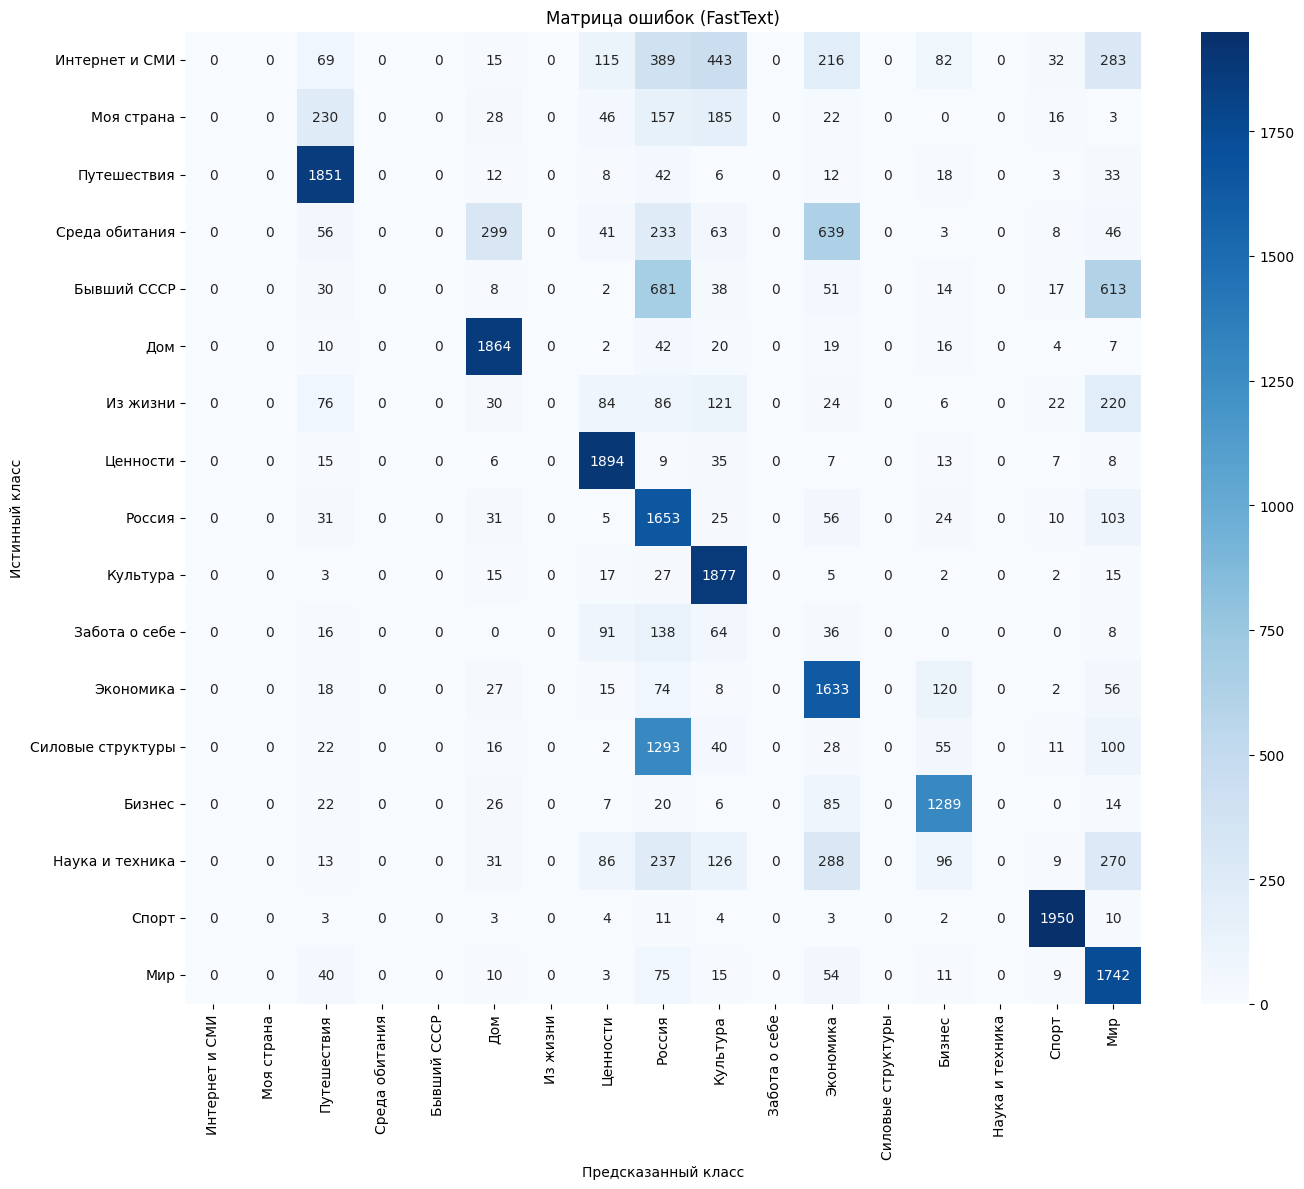

In [6]:
# 3️⃣ Предсказания на тесте и метрики
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Загружаем тестовые данные
test_data = list(zip(X_test.tolist(), y_test.tolist()))

y_true = []
y_pred = []

for text, true_label in test_data:
    clean_text = text.strip().replace('\n', ' ').replace('\r', ' ')
    pred_label = model.predict(clean_text)[0][0].replace('__label__', '')
    y_true.append(true_label)
    y_pred.append(pred_label)


# --- Метрики ---
print("Classification Report:")
print(classification_report(y_true, y_pred))

accuracy = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average='macro')
weighted_f1 = f1_score(y_true, y_pred, average='weighted')

print(f"\nОсновные метрики:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")
print(f"Weighted F1-score: {weighted_f1:.4f}")

# --- Матрица ошибок ---
cm = confusion_matrix(y_true, y_pred, labels=y_test.unique())

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=y_test.unique(),
    yticklabels=y_test.unique()
)
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.title('Матрица ошибок (FastText)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [9]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# --- Только реальные классы
all_classes = sorted(set(label.replace('__label__', '') for label in model.labels) & set(y_true))

# --- Проверка на достаточное количество классов
if len(all_classes) < 2:
    print("❗ Недостаточно классов для расчёта ROC AUC (нужно ≥ 2)")
    roc_auc = float('nan')
else:
    y_true_bin = label_binarize(y_true, classes=all_classes)
    y_pred_proba = []

    for text in X_test.tolist():
        clean_text = text.strip().replace('\n', ' ').replace('\r', ' ')
        pred = model.predict(clean_text, k=len(all_classes))
        probs = [0.0] * len(all_classes)
        for label, prob in zip(pred[0], pred[1]):
            label_clean = label.replace("__label__", "")
            if label_clean in all_classes:
                probs[all_classes.index(label_clean)] = prob
        y_pred_proba.append(probs)

    roc_auc = roc_auc_score(y_true_bin, y_pred_proba, average='macro')
    print(f"ROC AUC (macro): {roc_auc:.4f}")


ROC AUC (macro): 0.9804


In [18]:

def fasttext_evaluate(model, test_file):
    result = model.test(test_file)
    print(f"Количество примеров: {result[0]}")
    print(f"Точность (precision@1): {result[1]:.4f}")
    print(f"Recall (recall@1): {result[2]:.4f}")

fasttext_evaluate(model, 'fasttext_test.txt')


Количество примеров: 33416
Точность (precision@1): 0.9434
Recall (recall@1): 0.9434


In [19]:
text = "Россия подписала новое соглашение о научном сотрудничестве."
labels, probabilities = model.predict(text, k=3)  # Топ-3 вероятных класса

for lbl, prob in zip(labels, probabilities):
    print(f"Класс: {lbl.replace('__label__', '')}, вероятность: {prob:.4f}")

Класс: Мир, вероятность: 0.9598
Класс: Экономика, вероятность: 0.0402
Класс: Спорт, вероятность: 0.0001


In [20]:
import fasttext

# Загрузка модели
model = fasttext.load_model("fasttext_news_model.ftz")

# Пример предсказания
sample_text = "Президент подписал новый закон об экономике."
clean_text = sample_text.strip().replace('\n', ' ').replace('\r', ' ')
label = model.predict(clean_text)[0][0].replace('__label__', '')
prob = model.predict(clean_text)[1][0]

print(f"Предсказанный класс: {label} с вероятностью {prob:.4f}")

Предсказанный класс: Спорт с вероятностью 0.5357


# TextCNN (CNN для текстов)

In [1]:
import pandas as pd
df_balanced = pd.read_csv('lenta-ru-news_balanced.csv')  # укажи правильный путь к файлу

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 conv1d (Conv1D)             (None, 296, 128)          64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 17)                2193      
                                                             

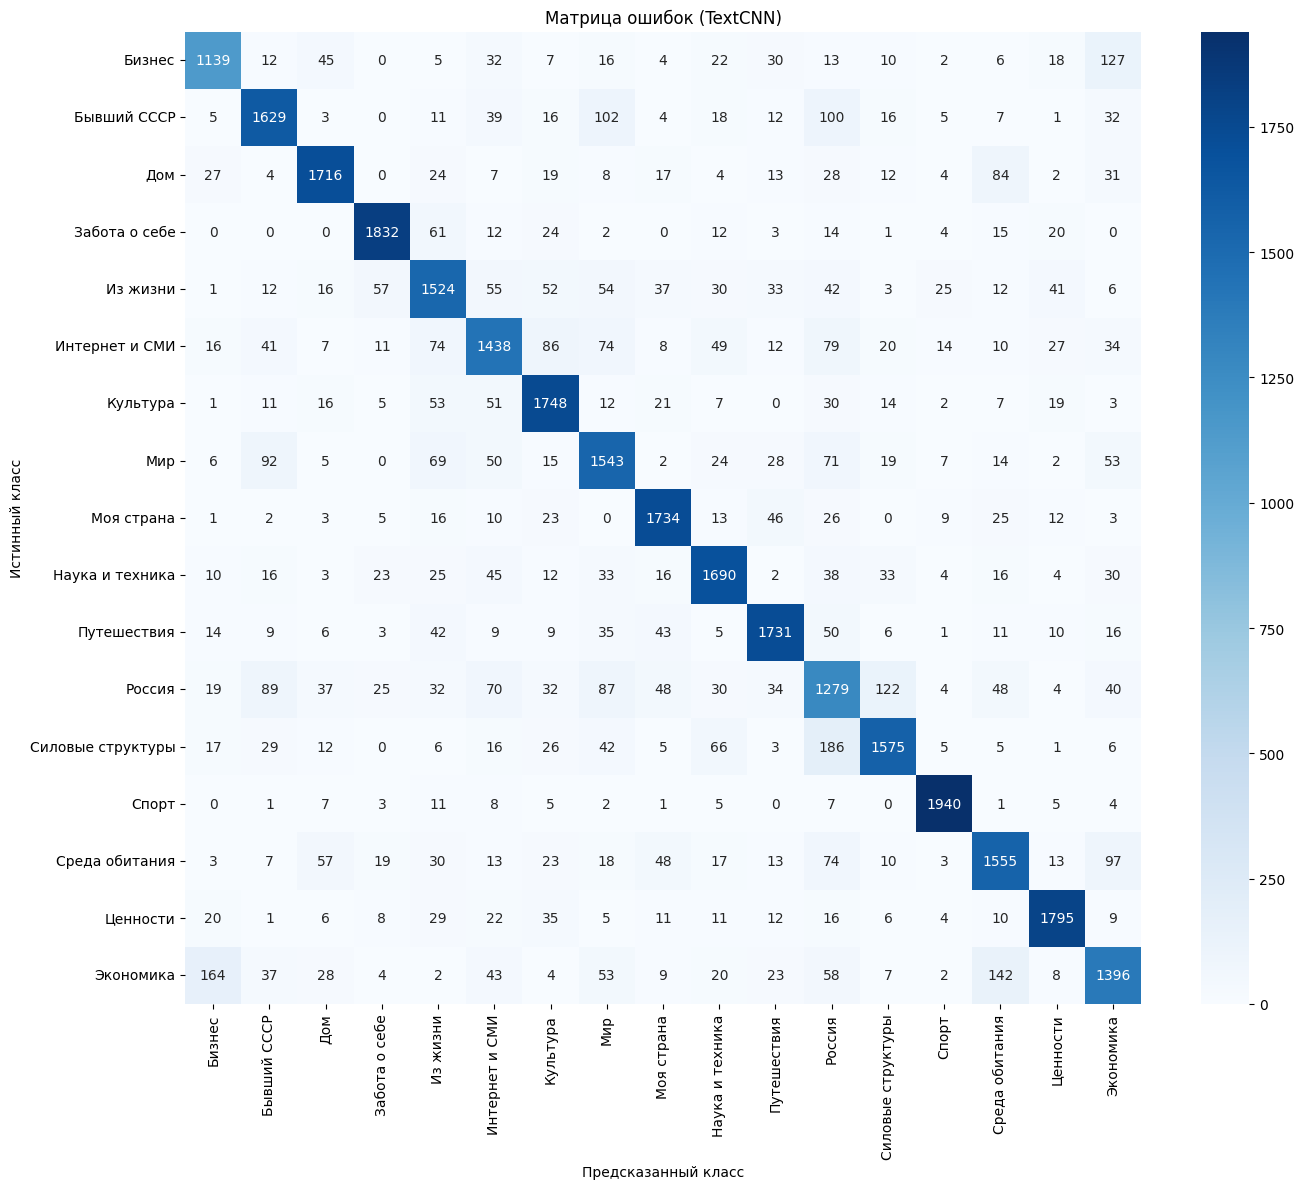

1/1 [==============================] - 0s 13ms/step
Предсказанная категория: Россия
Модель, токенизатор и LabelEncoder сохранены!


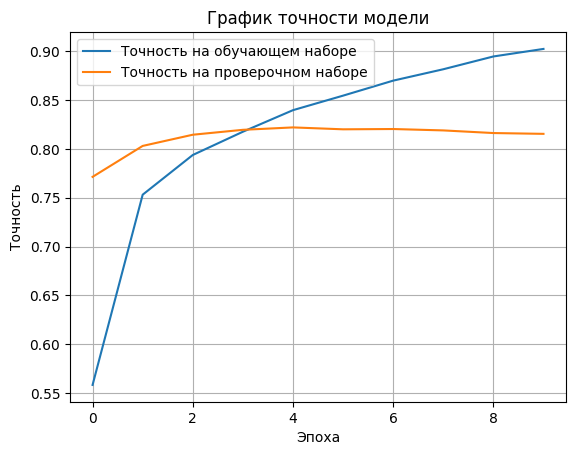

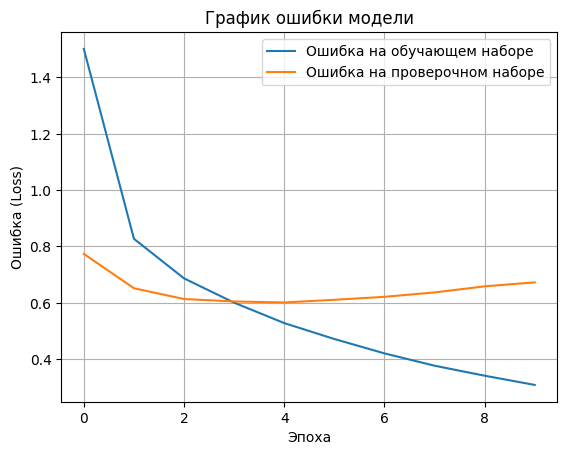

In [2]:
# --- Библиотеки ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# --- 1. Подготовка данных ---
texts = df_balanced['text']
labels = df_balanced['topic']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# --- 2. Кодируем метки ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

# --- 3. Токенизация и паддинг ---
max_words = 10000
max_len = 300

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# --- 4. Построение модели TextCNN ---
embedding_dim = 100
num_classes = len(le.classes_)

input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len)(input_layer)
conv_layer = Conv1D(128, 5, activation='relu')(embedding_layer)
pooling_layer = GlobalMaxPooling1D()(conv_layer)
dropout_layer = Dropout(0.5)(pooling_layer)
output_layer = Dense(num_classes, activation='softmax')(dropout_layer)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

# --- 5. Обучение ---
history = model.fit(
    X_train_pad, y_train_cat,
    epochs=10,
    batch_size=128,
    validation_split=0.1
)

# --- 6. Предсказания ---
y_pred_probs = model.predict(X_test_pad)
y_pred_enc = np.argmax(y_pred_probs, axis=1)
y_pred = le.inverse_transform(y_pred_enc)

# --- 7. Метрики ---
print("Classification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

# --- ROC AUC (macro) ---
y_test_bin = label_binarize(y_test_enc, classes=np.arange(len(le.classes_)))
roc_auc = roc_auc_score(y_test_bin, y_pred_probs, average='macro')

print(f"\nОсновные метрики:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")
print(f"Weighted F1-score: {weighted_f1:.4f}")
print(f"ROC AUC (macro): {roc_auc:.4f}")

# --- 8. Матрица ошибок ---
cm = confusion_matrix(y_test, y_pred, labels=le.classes_)

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.title('Матрица ошибок (TextCNN)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- 9. Функция для предсказания нового текста ---
def predict_new_text(text):
    clean_text = text.strip().lower()
    seq = tokenizer.texts_to_sequences([clean_text])
    padded = pad_sequences(seq, maxlen=max_len)
    pred_probs = model.predict(padded)
    pred_class = le.inverse_transform([np.argmax(pred_probs)])
    print(f"Предсказанная категория: {pred_class[0]}")

# Пример
predict_new_text("Президент подписал новый закон о науке и инновациях.")

# --- 10. Сохранение модели и объектов токенизации ---

# Сохраняем модель
model.save("textcnn_news_model.keras")

# Сохраняем Tokenizer
import pickle
with open("textcnn_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Сохраняем LabelEncoder
with open("textcnn_label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("Модель, токенизатор и LabelEncoder сохранены!")


plt.plot(history.history['accuracy'], label='Точность на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.title('График точности модели')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка (Loss)')
plt.title('График ошибки модели')
plt.legend()
plt.grid(True)
plt.show()


In [3]:
from tensorflow.keras.models import load_model
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# --- Загрузка ---
model = load_model("textcnn_news_model.keras")

with open("textcnn_tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

with open("textcnn_label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

max_len = 300  # важно, чтобы совпадало с обучением

# --- Функция предсказания ---
def predict_new_text(text):
    clean_text = text.strip().lower()
    seq = tokenizer.texts_to_sequences([clean_text])
    padded = pad_sequences(seq, maxlen=max_len)
    pred_probs = model.predict(padded)
    pred_class = le.inverse_transform([np.argmax(pred_probs)])
    print(f"Предсказанная категория: {pred_class[0]}")

# Пример
predict_new_text("Президент подписал новый закон о науке и инновациях.")


1/1 [==============================] - 0s 44ms/step
Предсказанная категория: Россия


# Simple LSTM (на Embedding-слое, Keras)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 17)                2193      
                                                                 
Total params: 1,119,441
Trainable params: 1,119,441
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
940/940 [==============================] - 15s 15ms/step - loss: 2.1491 - accuracy: 0.2684 - val_loss: 1.6373 - val_accuracy: 0.4679
Epoch 2/10
940/940 [==============

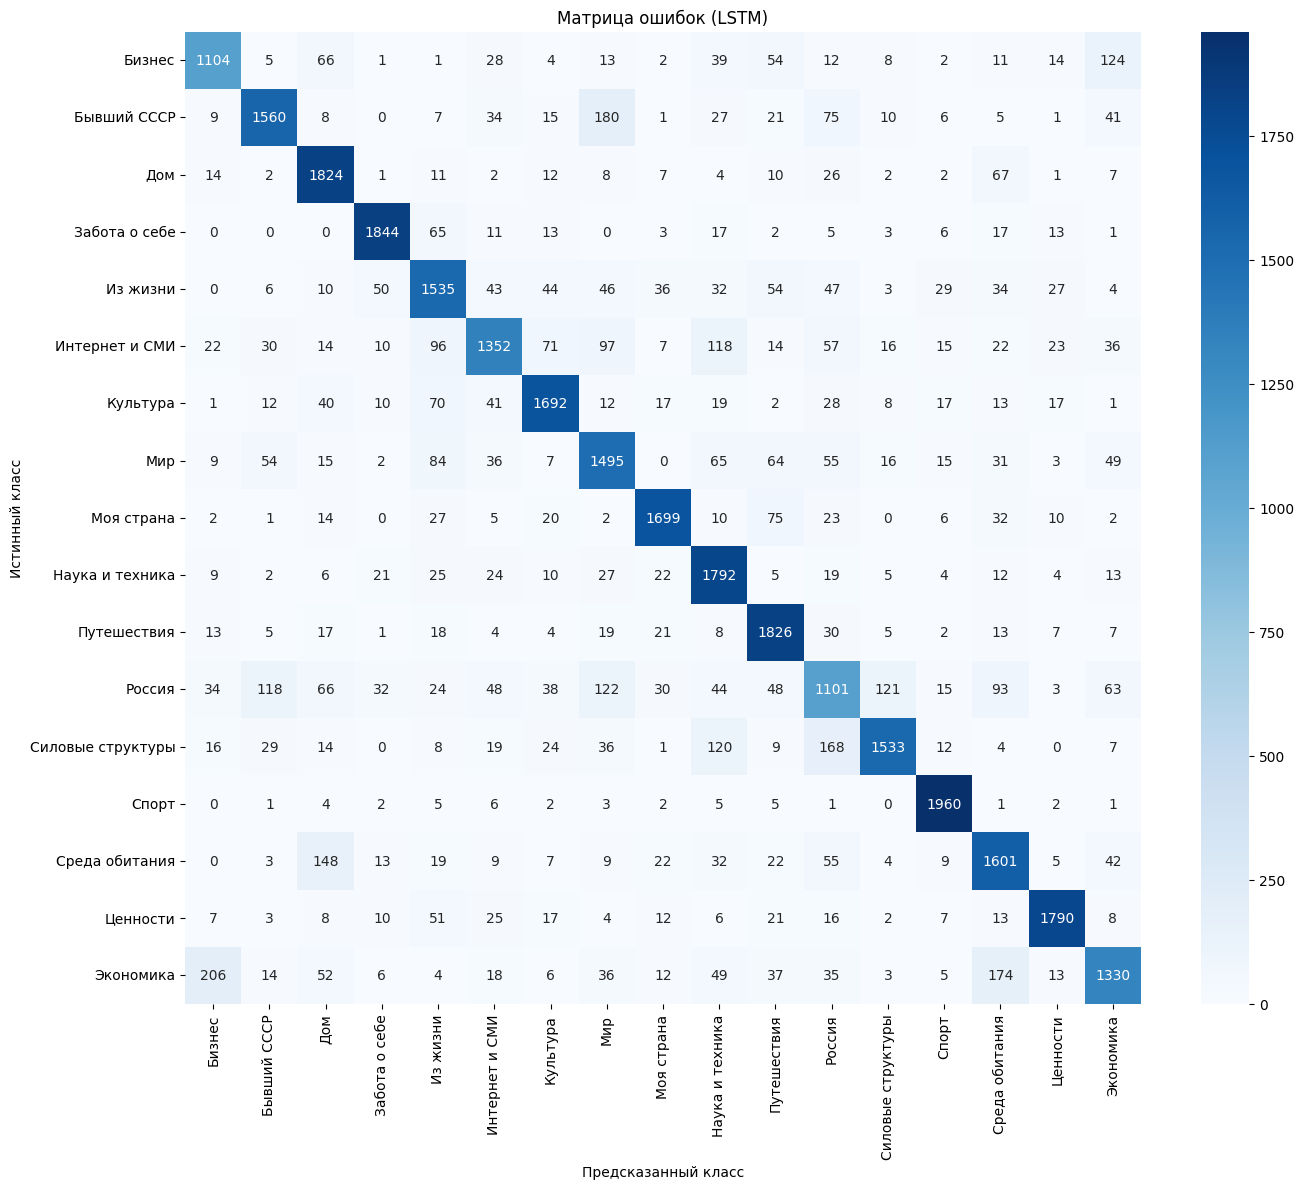

Модель LSTM, токенизатор и LabelEncoder успешно сохранены!


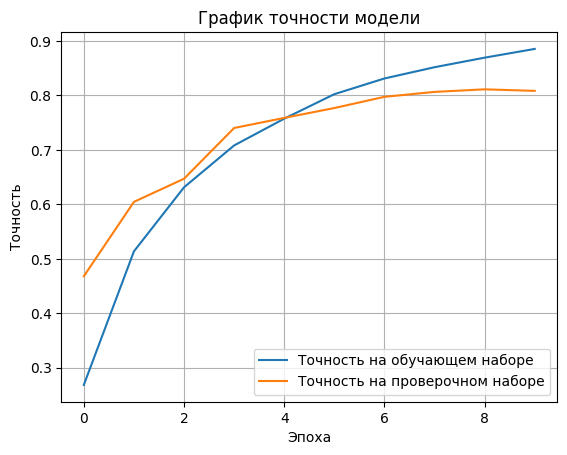

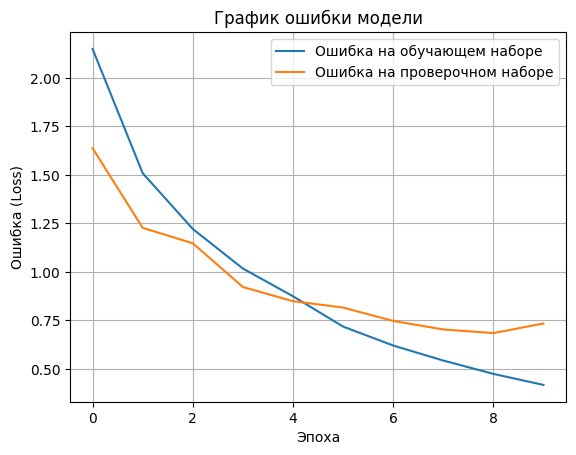

In [4]:
# --- Импорт библиотек ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# --- 1. Подготовка данных ---

texts = df_balanced['text']
labels = df_balanced['topic']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# Кодируем метки
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# One-hot для Keras
y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

# --- 2. Токенизация и паддинг ---

max_words = 10000
max_len = 300

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# --- 3. Построение модели LSTM ---

embedding_dim = 100
num_classes = len(le.classes_)

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

# --- 4. Обучение модели ---

history = model.fit(
    X_train_pad, y_train_cat,
    epochs=10,
    batch_size=128,
    validation_split=0.1
)

# --- 5. Оценка качества ---

y_pred_probs = model.predict(X_test_pad)
y_pred_enc = np.argmax(y_pred_probs, axis=1)
y_pred = le.inverse_transform(y_pred_enc)

# --- ROC AUC (macro) ---
# Бинаризуем метки
y_test_bin = label_binarize(y_test_enc, classes=np.arange(len(le.classes_)))

# Вычисляем ROC AUC
roc_auc = roc_auc_score(y_test_bin, y_pred_probs, average='macro')

print("Classification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nОсновные метрики:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")
print(f"Weighted F1-score: {weighted_f1:.4f}")
print(f"ROC AUC (macro): {roc_auc:.4f}")

# --- 6. Матрица ошибок ---

cm = confusion_matrix(y_test, y_pred, labels=le.classes_)

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.title('Матрица ошибок (LSTM)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# --- 7. Сохранение модели, токенизатора и LabelEncoder ---

# Сохраняем модель
model.save("lstm_news_model.keras")

# Сохраняем Tokenizer
import pickle
with open("lstm_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Сохраняем LabelEncoder
with open("lstm_label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("Модель LSTM, токенизатор и LabelEncoder успешно сохранены!")

plt.plot(history.history['accuracy'], label='Точность на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.title('График точности модели')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка (Loss)')
plt.title('График ошибки модели')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
from tensorflow.keras.models import load_model
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# --- Загрузка ---
model = load_model("lstm_news_model.keras")

with open("lstm_tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

with open("lstm_label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

max_len = 300  # должно совпадать с обучением

# --- Функция предсказания ---
def predict_new_text(text):
    clean_text = text.strip().lower()
    seq = tokenizer.texts_to_sequences([clean_text])
    padded = pad_sequences(seq, maxlen=max_len)
    pred_probs = model.predict(padded)
    pred_class = le.inverse_transform([np.argmax(pred_probs)])
    print(f"Предсказанная категория: {pred_class[0]}")

# Пример использования
predict_new_text("Президент подписал законопроект о развитии науки и технологий.")


1/1 [==============================] - 0s 159ms/step
Предсказанная категория: Россия


In [ ]:
# --- Импорт библиотек ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# --- 1. Подготовка данных ---

texts = df_balanced['text']
labels = df_balanced['topic']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# Кодируем метки
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# One-hot для Keras
y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

# --- 2. Токенизация и паддинг ---

max_words = 10000
max_len = 300

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# --- 3. Построение модели GRU ---

embedding_dim = 100
num_classes = len(le.classes_)

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(GRU(128))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

# --- 4. Обучение модели ---

history = model.fit(
    X_train_pad, y_train_cat,
    epochs=10,
    batch_size=128,
    validation_split=0.1
)

# --- 5. Оценка качества ---

y_pred_probs = model.predict(X_test_pad)
y_pred_enc = np.argmax(y_pred_probs, axis=1)
y_pred = le.inverse_transform(y_pred_enc)

# --- ROC AUC (macro) ---
# Бинаризуем метки
y_test_bin = label_binarize(y_test_enc, classes=np.arange(len(le.classes_)))

# Вычисляем ROC AUC
roc_auc = roc_auc_score(y_test_bin, y_pred_probs, average='macro')

print("Classification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nОсновные метрики:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")
print(f"Weighted F1-score: {weighted_f1:.4f}")
print(f"ROC AUC (macro): {roc_auc:.4f}")

# --- 6. Матрица ошибок ---

cm = confusion_matrix(y_test, y_pred, labels=le.classes_)

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.title('Матрица ошибок (GRU)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- Импорт библиотек ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Подготовка данных ---

texts = df_balanced['text']
labels = df_balanced['topic']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# Кодируем метки
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# One-hot для Keras
y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

# --- 2. Токенизация и паддинг ---

max_words = 10000
max_len = 300

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# --- 3. Построение модели GRU ---

embedding_dim = 100
num_classes = len(le.classes_)

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(GRU(128))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

# --- 4. Обучение модели ---

history = model.fit(
    X_train_pad, y_train_cat,
    epochs=10,
    batch_size=128,
    validation_split=0.1
)

# --- 5. Оценка качества ---

y_pred_probs = model.predict(X_test_pad)
y_pred_enc = np.argmax(y_pred_probs, axis=1)
y_pred = le.inverse_transform(y_pred_enc)

print("Classification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nОсновные метрики:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")
print(f"Weighted F1-score: {weighted_f1:.4f}")

# --- 6. Матрица ошибок ---

cm = confusion_matrix(y_test, y_pred, labels=le.classes_)

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.title('Матрица ошибок (GRU)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- 7. Сохранение модели, токенизатора и LabelEncoder ---

# Сохраняем модель
model.save("gru_news_model.keras")

# Сохраняем Tokenizer
import pickle
with open("gru_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Сохраняем LabelEncoder
with open("gru_label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("Модель GRU, токенизатор и LabelEncoder успешно сохранены!")

plt.plot(history.history['accuracy'], label='Точность на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.title('График точности модели')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка (Loss)')
plt.title('График ошибки модели')
plt.legend()
plt.grid(True)
plt.show()


KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.models import load_model
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# --- Загрузка ---
model = load_model("gru_news_model.keras")

with open("gru_tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

with open("gru_label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

max_len = 300  # как в обучении

# --- Функция предсказания ---
def predict_new_text(text):
    clean_text = text.strip().lower()
    seq = tokenizer.texts_to_sequences([clean_text])
    padded = pad_sequences(seq, maxlen=max_len)
    pred_probs = model.predict(padded)
    pred_class = le.inverse_transform([np.argmax(pred_probs)])
    print(f"Предсказанная категория: {pred_class[0]}")

# Пример
predict_new_text("Президент подписал закон о поддержке бизнеса.")


1/1 [==============================] - 0s 144ms/step
Предсказанная категория: Ценности
